# Predicting NYC AirBnb Prices 

In [751]:
!pip install geopy

In [752]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings(action='once')

In [753]:
# reading in air BnB data and NYC property sales data
df = pd.read_csv('abnyc.csv')
sales_df = pd.read_csv('nyc_sales.csv')
crime_df = pd.read_csv('NYPD_Complaint_Data_Historic.csv')

/Applications/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (18,20) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [754]:
print(df.shape)
print(sales_df.shape)
print(crime_df.shape)

(48895, 16)
(84548, 22)
(6500870, 35)


## NYC Property Sales DataFrame

In [755]:
sales_df.head()

,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,...,5,0,5,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00
1,5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,...,28,3,31,4616,18690,1900,2,C7,-,2016-12-14 00:00:00
2,6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,...,16,1,17,2212,7803,1900,2,C7,-,2016-12-09 00:00:00
3,7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,...,10,0,10,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00
4,8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,...,6,0,6,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00


In [756]:
# check for null values
sales_df.isnull().sum()

Unnamed: 0                        0
BOROUGH                           0
NEIGHBORHOOD                      0
BUILDING CLASS CATEGORY           0
TAX CLASS AT PRESENT              0
BLOCK                             0
LOT                               0
EASE-MENT                         0
BUILDING CLASS AT PRESENT         0
ADDRESS                           0
APARTMENT NUMBER                  0
ZIP CODE                          0
RESIDENTIAL UNITS                 0
COMMERCIAL UNITS                  0
TOTAL UNITS                       0
LAND SQUARE FEET                  0
GROSS SQUARE FEET                 0
YEAR BUILT                        0
TAX CLASS AT TIME OF SALE         0
BUILDING CLASS AT TIME OF SALE    0
SALE PRICE                        0
SALE DATE                         0
dtype: int64

In [757]:
# null sale prices are encoded by "-" so we will get rid of these rows 
sales_df = sales_df[sales_df['SALE PRICE'] != ' -  ']
sales_df.shape

(69987, 22)

In [758]:
# map bouroughs to actual names
# Manhattan (1), Bronx (2), Brooklyn (3), Queens (4), and Staten Island (5)
map_dict = {1: 'Manhattan', 2: 'Bronx', 3: 'Brooklyn', 4: 'Queens', 5: 'Staten Island'}
sales_df['neighbourhood_group'] = sales_df['BOROUGH'].map(map_dict)

In [759]:
# make sure counts match
sales_df['BOROUGH'].value_counts()

3    24047
4    18441
1    14439
2     7049
5     6011
Name: BOROUGH, dtype: int64

In [760]:
sales_df['neighbourhood_group'].value_counts()

Brooklyn         24047
Queens           18441
Manhattan        14439
Bronx             7049
Staten Island     6011
Name: neighbourhood_group, dtype: int64

In [761]:
# convert sale price to numeric
sales_df['SALE PRICE'] = pd.to_numeric(sales_df['SALE PRICE'])

In [762]:
# avg sale price by borough
median_sales = sales_df.groupby('neighbourhood_group')['SALE PRICE'].median()
sales_dict = median_sales.to_dict()
sales_dict

{'Bronx': 270000,
 'Brooklyn': 420000,
 'Manhattan': 1150000,
 'Queens': 495000,
 'Staten Island': 465000}

## NYC Crimes DataFrame

In [763]:
crime_df.head()

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,...,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX
0,522575447,08/29/2006,13:00:00,NaN,NaN,43.0,08/30/2006,578,HARRASSMENT 2,638.0,...,M,NaN,40.827414,-73.877946,"(40.827414051, -73.877945775)",PATROL BORO BRONX,NaN,25-44,BLACK HISPANIC,F
1,403507361,11/05/2006,11:00:00,11/05/2006,17:40:00,66.0,11/05/2006,107,BURGLARY,221.0,...,NaN,NaN,40.637097,-74.006105,"(40.637096864, -74.006105014)",PATROL BORO BKLYN SOUTH,NaN,45-64,ASIAN / PACIFIC ISLANDER,F
2,631420068,09/08/2006,23:30:00,09/09/2006,00:01:00,106.0,09/09/2006,347,INTOXICATED & IMPAIRED DRIVING,905.0,...,NaN,NaN,40.679260,-73.841500,"(40.679260229, -73.841500185)",PATROL BORO QUEENS SOUTH,NaN,NaN,UNKNOWN,E
3,995609899,12/13/2011,18:40:00,12/13/2011,18:49:00,79.0,12/13/2011,341,PETIT LARCENY,333.0,...,NaN,NaN,40.687402,-73.940369,"(40.687401619, -73.940369194)",PATROL BORO BKLYN NORTH,NaN,NaN,UNKNOWN,D
4,480667624,08/14/2009,04:20:00,NaN,NaN,30.0,08/14/2009,113,FORGERY,729.0,...,NaN,NaN,40.831576,-73.942983,"(40.831576128, -73.942982699)",PATROL BORO MAN NORTH,NaN,NaN,UNKNOWN,E


In [764]:
crime_df.dtypes

CMPLNT_NUM             int64
CMPLNT_FR_DT          object
CMPLNT_FR_TM          object
CMPLNT_TO_DT          object
CMPLNT_TO_TM          object
ADDR_PCT_CD          float64
RPT_DT                object
KY_CD                  int64
OFNS_DESC             object
PD_CD                float64
PD_DESC               object
CRM_ATPT_CPTD_CD      object
LAW_CAT_CD            object
BORO_NM               object
LOC_OF_OCCUR_DESC     object
PREM_TYP_DESC         object
JURIS_DESC            object
JURISDICTION_CODE    float64
PARKS_NM              object
HADEVELOPT            object
HOUSING_PSA           object
X_COORD_CD           float64
Y_COORD_CD           float64
SUSP_AGE_GROUP        object
SUSP_RACE             object
SUSP_SEX              object
TRANSIT_DISTRICT     float64
Latitude             float64
Longitude            float64
Lat_Lon               object
PATROL_BORO           object
STATION_NAME          object
VIC_AGE_GROUP         object
VIC_RACE              object
VIC_SEX       

In [765]:
# check for null values
crime_df.isnull().sum().sort_values()

CMPLNT_NUM                 0
JURIS_DESC                 0
LAW_CAT_CD                 0
KY_CD                      0
RPT_DT                     0
CRM_ATPT_CPTD_CD           7
CMPLNT_FR_TM              48
VIC_SEX                  304
VIC_RACE                 305
CMPLNT_FR_DT             655
ADDR_PCT_CD             2166
JURISDICTION_CODE       5496
PD_CD                   5496
PD_DESC                 5496
PATROL_BORO             5953
BORO_NM                10518
Lat_Lon                17339
Longitude              17339
Latitude               17339
Y_COORD_CD             17339
X_COORD_CD             17339
OFNS_DESC              18805
PREM_TYP_DESC          37703
LOC_OF_OCCUR_DESC    1394809
CMPLNT_TO_TM         1602801
CMPLNT_TO_DT         1607101
VIC_AGE_GROUP        1638441
SUSP_RACE            3222422
SUSP_SEX             3355736
SUSP_AGE_GROUP       4590963
HOUSING_PSA          5998248
HADEVELOPT           6177206
TRANSIT_DISTRICT     6356760
STATION_NAME         6356760
PARKS_NM      

In [766]:
type(crime_df['RPT_DT'][0])

str

In [767]:
# extract the year from 'CMPLNT_FR_DT''
crime_df['years'] = crime_df['RPT_DT'].apply(lambda x: x[6:])

In [768]:
# select relevant features (parks_nm, station_nm, ...)
crime_df = crime_df[['CMPLNT_NUM', 'LAW_CAT_CD', 'RPT_DT', 'BORO_NM', 'years', 'Latitude', 'Longitude']]

In [769]:
crime_df.head()

,CMPLNT_NUM,LAW_CAT_CD,RPT_DT,BORO_NM,years,Latitude,Longitude
0,522575447,VIOLATION,08/30/2006,BRONX,2006,40.827414,-73.877946
1,403507361,FELONY,11/05/2006,BROOKLYN,2006,40.637097,-74.006105
2,631420068,MISDEMEANOR,09/09/2006,QUEENS,2006,40.679260,-73.841500
3,995609899,MISDEMEANOR,12/13/2011,BROOKLYN,2011,40.687402,-73.940369
4,480667624,FELONY,08/14/2009,MANHATTAN,2009,40.831576,-73.942983


In [770]:
# check for null values with revised dataframe
crime_df.isnull().sum()

CMPLNT_NUM        0
LAW_CAT_CD        0
RPT_DT            0
BORO_NM       10518
years             0
Latitude      17339
Longitude     17339
dtype: int64

In [771]:
# percent of missing data for 'BORO_NM'
(crime_df['BORO_NM'].isnull().sum() / crime_df.shape[0]) * 100

0.16179372914702186

In [772]:
# percent of missing data for 'Latitude'
(crime_df['Latitude'].isnull().sum() / crime_df.shape[0]) * 100

0.26671814695571516

In [773]:
# percent of missing data for 'Longitude'
(crime_df['Longitude'].isnull().sum() / crime_df.shape[0]) * 100

0.26671814695571516

In [774]:
# remove null values and corresponding rows
crime_df.dropna(axis=0, how='any', inplace=True)

In [775]:
# check null values and new shape
print(crime_df.isnull().sum())
crime_df.shape # 6500870 - 10518 = 6490352

CMPLNT_NUM    0
LAW_CAT_CD    0
RPT_DT        0
BORO_NM       0
years         0
Latitude      0
Longitude     0
dtype: int64


(6473470, 7)

In [776]:
# shape of revised dataframe
print('Crime features: ', crime_df.shape[0])
print('Crime rows: ', crime_df.shape[1])

Crime features:  6473470
Crime rows:  7


In [777]:
# check unique values in 'BORO_NM'
print(crime_df['BORO_NM'].unique())
crime_df['BORO_NM'].value_counts()

['BRONX' 'BROOKLYN' 'QUEENS' 'MANHATTAN' 'STATEN ISLAND']


BROOKLYN         1929853
MANHATTAN        1554093
BRONX            1404795
QUEENS           1278578
STATEN ISLAND     306151
Name: BORO_NM, dtype: int64

In [778]:
# map 'BORO_NM' to numeric values
# Manhattan (1), Bronx (2), Brooklyn (3), Queens (4), and Staten Island (5)
map_dict = {'MANHATTAN': 1, 'BRONX': 2, 'BROOKLYN': 3, 'QUEENS': 4, 'STATEN ISLAND': 5}
crime_df['Borough'] = crime_df['BORO_NM'].map(map_dict)

In [779]:
# check mapping was correct
print(crime_df['Borough'].unique())
crime_df['Borough'].value_counts()

[2 3 4 1 5]


3    1929853
1    1554093
2    1404795
4    1278578
5     306151
Name: Borough, dtype: int64

In [780]:
# select instances from 2008 (AirBNB Launch) to present
crime_df = crime_df.loc[crime_df['years'] > '2007', :]

In [781]:
# shape of revised dataframe
print('Crime features: ', crime_df.shape[0])
print('Crime rows: ', crime_df.shape[1])

Crime features:  5426072
Crime rows:  8


In [782]:
# check the value counts for 'LAW_CAT_CD'
print(crime_df['LAW_CAT_CD'].value_counts())

MISDEMEANOR    3089617
FELONY         1652336
VIOLATION       684119
Name: LAW_CAT_CD, dtype: int64


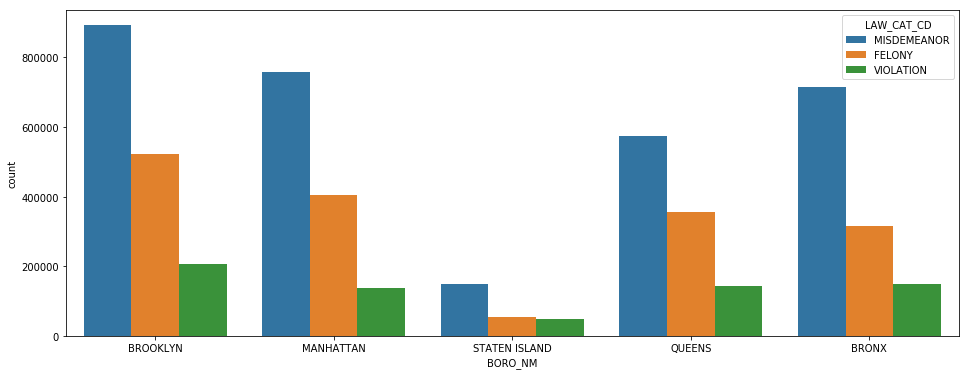

In [783]:
# visualize the frequency of crimes in each Borough
plt.figure(figsize=(16, 6))
ax = sns.countplot(x='BORO_NM', hue='LAW_CAT_CD', data=crime_df)

In [784]:
crime_df.head()

,CMPLNT_NUM,LAW_CAT_CD,RPT_DT,BORO_NM,years,Latitude,Longitude,Borough
3,995609899,MISDEMEANOR,12/13/2011,BROOKLYN,2011,40.687402,-73.940369,3
4,480667624,FELONY,08/14/2009,MANHATTAN,2009,40.831576,-73.942983,1
5,605915885,FELONY,10/29/2009,BROOKLYN,2009,40.643368,-73.905059,3
8,211477358,MISDEMEANOR,07/08/2008,MANHATTAN,2008,40.849415,-73.939425,1
11,537893224,MISDEMEANOR,04/27/2009,STATEN ISLAND,2009,40.591872,-74.086027,5


In [785]:
# total number of crimes per year
crime_df.groupby('years').size()

years
2008    527957
2009    511986
2010    507128
2011    498061
2012    503919
2013    496901
2014    490989
2015    478215
2016    478527
2017    468660
2018    463729
dtype: int64

In [786]:
# total amount of crime per borough from 2008 - 2018
sum_crimes = crime_df.groupby('BORO_NM')['LAW_CAT_CD'].size()
sum_crimes

BORO_NM
BRONX            1179814
BROOKLYN         1621382
MANHATTAN        1300041
QUEENS           1070997
STATEN ISLAND     253838
Name: LAW_CAT_CD, dtype: int64

In [787]:
# total amount of crime per borough (distinction in crime)
crime_df.groupby(['BORO_NM', 'LAW_CAT_CD']).size()

BORO_NM        LAW_CAT_CD 
BRONX          FELONY         316336
               MISDEMEANOR    715754
               VIOLATION      147724
BROOKLYN       FELONY         522712
               MISDEMEANOR    891785
               VIOLATION      206885
MANHATTAN      FELONY         403270
               MISDEMEANOR    758073
               VIOLATION      138698
QUEENS         FELONY         354368
               MISDEMEANOR    574059
               VIOLATION      142570
STATEN ISLAND  FELONY          55650
               MISDEMEANOR    149946
               VIOLATION       48242
dtype: int64

In [788]:
# average amount of crime per borough from 2008 - 2018
crimes_per_year = crime_df.groupby(['BORO_NM', 'years']).size()
crimes_per_year

BORO_NM        years
BRONX          2008     114191
               2009     112973
               2010     111566
               2011     108657
               2012     106787
               2013     104412
               2014     105854
               2015     104900
               2016     106012
               2017     103473
               2018     100989
BROOKLYN       2008     155632
               2009     150739
               2010     151482
               2011     151497
               2012     154885
               2013     150184
               2014     148700
               2015     143115
               2016     140600
               2017     137700
               2018     136848
MANHATTAN      2008     128514
               2009     124811
               2010     121391
               2011     115844
               2012     119706
               2013     118293
               2014     113344
               2015     113227
               2016     115623
               201

In [789]:
# average crime per Borough from 2008 to 2018
manh_avg = crimes_per_year['MANHATTAN'].mean()
bronx_avg = crimes_per_year['BRONX'].mean()
brook_avg = crimes_per_year['BROOKLYN'].mean()
queen_avg = crimes_per_year['QUEENS'].mean()
stat_avg = crimes_per_year['STATEN ISLAND'].mean()

In [790]:
# crime rate per borough = total number of crimes in Borough X / total population in Borough X
# population of borough comes from 2017
manhattan_pop = 1664727
bronx_pop = 1471160
brooklyn_pop = 2648771
queens_pop = 2358582
staten_island_pop = 479458

manh_pct = (manh_avg / manhattan_pop) * 100
bronx_pct = (bronx_avg / bronx_pop) * 100
brook_pct = (brook_avg / brooklyn_pop) * 100
queen_pct = (queen_avg / queens_pop) * 100
stat_pct = (stat_avg / staten_island_pop) * 100

crime_rates = {'Manhattan': manh_pct, 
               'Bronx': bronx_pct, 
               'Brooklyn': brook_pct, 
               'Queens': queen_pct, 
               'Staten Island': stat_pct}

In [791]:
# Crime Rate average per borough
print('Manhattan: ', manh_pct)
print('Bronx:     ', bronx_pct)
print('Brooklyn:  ', brook_pct)
print('Queens:    ', queen_pct)
print('Staten Island: ', stat_pct)

Manhattan:  7.099395003177425
Bronx:      7.290561066221089
Brooklyn:   5.564783200826484
Queens:     4.128046582071924
Staten Island:  4.8129725269328745


In [792]:
# max and min Latitude and Longitude
print('Max Latitude:  ', max(crime_df['Latitude']))
print('Min Latitude:  ', min(crime_df['Latitude']))
print('Max Longitude: ', max(crime_df['Longitude']))
print('Min Longitude: ', min(crime_df['Longitude']))

Max Latitude:   59.657273946000004
Min Latitude:   40.498905363
Max Longitude:  -73.684788384
Min Longitude:  -74.254938736


In [793]:
# filter out Latitude and Longitude to fit in colormap
min_lat = 40.49
max_lat = 40.92
min_long = -74.25
max_long = -73.70

colormap_app = crime_df.loc[(crime_df['Latitude'] >= min_lat) &
                        (crime_df['Latitude'] <= max_lat) &
                        (crime_df['Longitude'] >= min_long) &
                        (crime_df['Longitude'] <= max_long), :]

In [794]:
# shape of revised dataframe
print('Crime features: ', colormap_app.shape[0])
print('Crime rows: ', colormap_app.shape[1])

Crime features:  5424616
Crime rows:  8


In [795]:
colormap_app_df = colormap_app.sample(n=50000)
colormap_app_df.shape

(50000, 8)

In [ ]:
# visualization of crime on NYC map
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(14, 10))
map_img = plt.imread('New_York_City_.png', 0)
plt.imshow(map_img, extent=[-74.250, -73.7, 40.49, 40.92], alpha=0.6)
sns.scatterplot(data=colormap_app_df, x='Longitude', y='Latitude', hue='BORO_NM', legend='full'

## AirBnB DataFrame

### Data Pre-Processing/EDA

In [578]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [579]:
# checking unique listings and hosts
print(len(df['id'].unique()))
print(len(df['host_id'].unique()))

48895
37457


In [580]:
#checking null values
df.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [581]:
# last_review and reviews_per_month is null for rows where num reviews is 0
df[df['number_of_reviews'] == 0].shape

(10052, 16)

In [582]:
# drop unnecessary columns that will not be used for prediction purposes 
cols = ['id','name','host_id','host_name', 'last_review']
df = df.drop(columns = cols)
df.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,0.21,6,365
1,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,0.38,2,355
2,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,1,365
3,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,4.64,1,194
4,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,0.10,1,0


In [583]:
# fill null values with 0
df = df.fillna(0)
df.isnull().sum()

neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

In [584]:
# checking value counts for various features
df['neighbourhood_group'].value_counts()

Manhattan        21661
Brooklyn         20104
Queens            5666
Bronx             1091
Staten Island      373
Name: neighbourhood_group, dtype: int64

In [585]:
df['neighbourhood'].value_counts()

Williamsburg                  3920
Bedford-Stuyvesant            3714
Harlem                        2658
Bushwick                      2465
Upper West Side               1971
Hell's Kitchen                1958
East Village                  1853
Upper East Side               1798
Crown Heights                 1564
Midtown                       1545
East Harlem                   1117
Greenpoint                    1115
Chelsea                       1113
Lower East Side                911
Astoria                        900
Washington Heights             899
West Village                   768
Financial District             744
Flatbush                       621
Clinton Hill                   572
Long Island City               537
Prospect-Lefferts Gardens      535
Park Slope                     506
East Flatbush                  500
Fort Greene                    489
Murray Hill                    485
Kips Bay                       470
Flushing                       426
Ridgewood           

In [586]:
df['room_type'].value_counts()

Entire home/apt    25409
Private room       22326
Shared room         1160
Name: room_type, dtype: int64

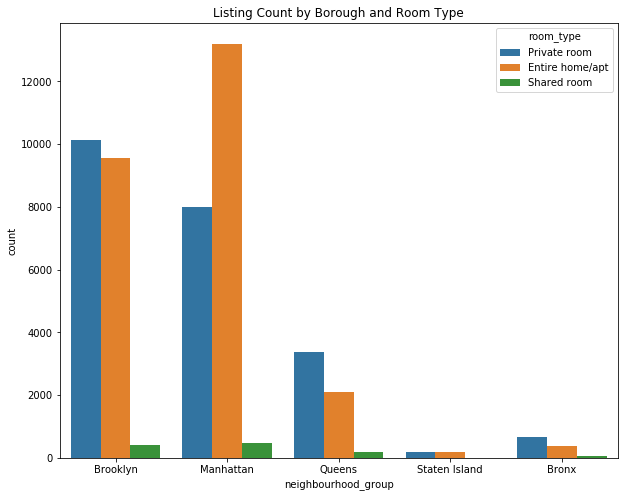

In [728]:
plt.figure(figsize = (10,8))
plt.title("Listing Count by Borough and Room Type")
sns.countplot(x = 'neighbourhood_group',hue = "room_type",data = df)
plt.show()

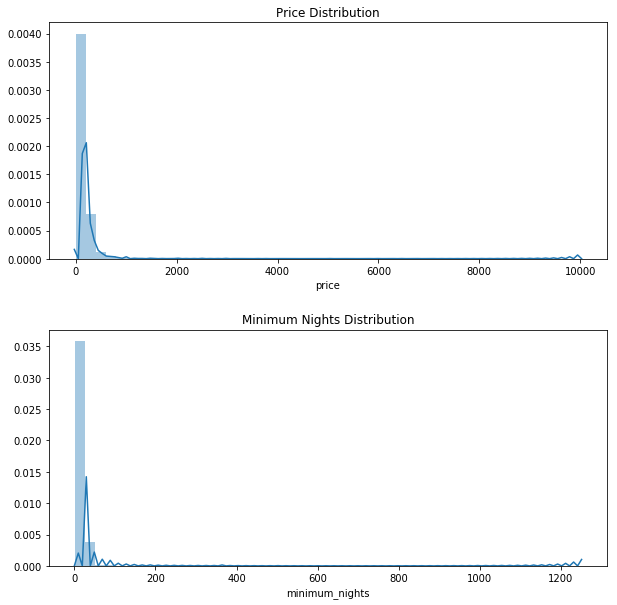

In [701]:
# Examining distribution of price and minimum nights
# Both distributions seem very skewed
plt.figure(figsize = (10,10))

plt.subplot(2,1,1)
plt.title('Price Distribution')
sns.distplot(df['price'])

plt.subplot(2,1,2)
plt.title('Minimum Nights Distribution')
sns.distplot(df['minimum_nights']);
 
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

In [589]:
# removing outliers to see if we have any changes in the distribution
# checking how many outliers there are
print(df[df['price'] < 1].shape)
print(df[df['price'] > 500].shape)
print(df[df['minimum_nights'] > 30].shape)

(11, 11)
(1044, 11)
(747, 11)


In [702]:
# remove outliers
clean_df = df[(df['price'] < 500) & (df['price'] > 0) & (df['minimum_nights'] < 60)]
clean_df.shape

(47236, 11)

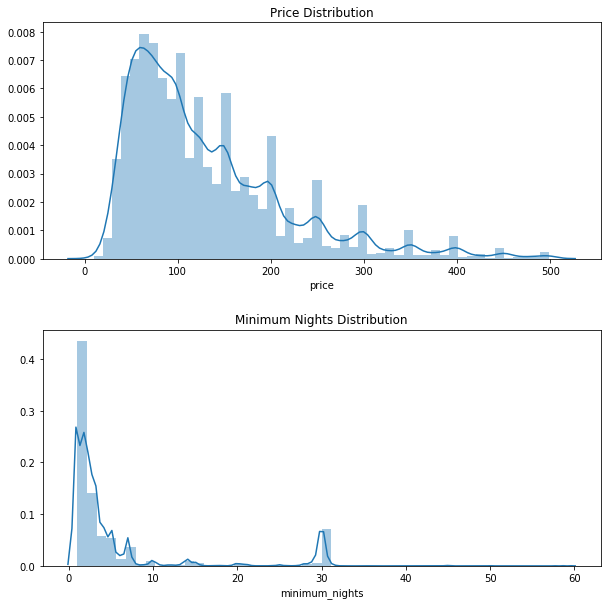

In [703]:
# Examining distributions after removing outliers
# Distributions are still skewed but not as bad as before. We can notice some trends.
plt.figure(figsize = (10,10))

plt.subplot(2,1,1)
plt.title('Price Distribution')
sns.distplot(clean_df['price'])

plt.subplot(2,1,2)
plt.title('Minimum Nights Distribution')
sns.distplot(clean_df['minimum_nights']);
 
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

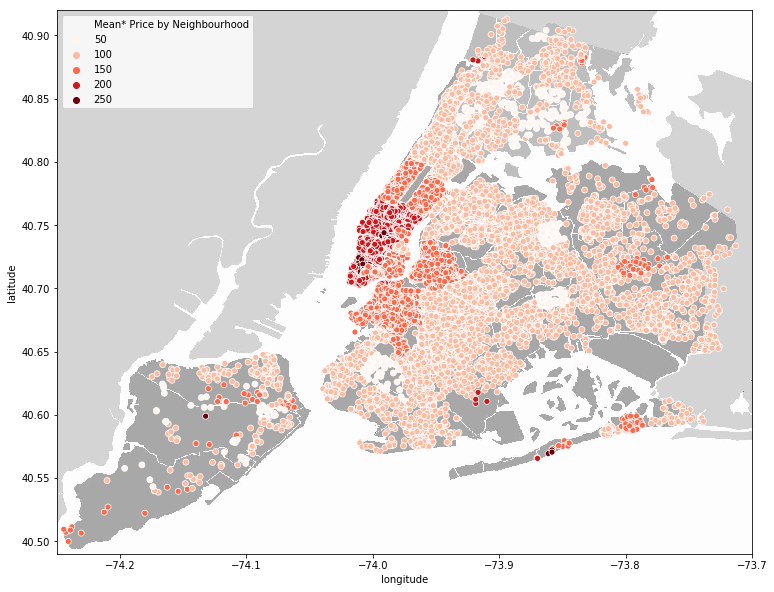

In [705]:
# Price per neighbourhood on NY Map
def round_to_threshold(num, threshold=50.0):
    num = np.mean(num)
    num = round(num / threshold) * threshold
    return num

price_by_neighbourhood_1 = clean_df.groupby('neighbourhood').agg({'price': round_to_threshold})
price_by_neighbourhood_1 = clean_df.merge(price_by_neighbourhood_1, on='neighbourhood', left_index=True)
price_by_neighbourhood_1 = price_by_neighbourhood_1.rename(columns={'price_x': 'price', 'price_y': 'Mean* Price by Neighbourhood', 'price_z': 'Mean Price'})

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(14, 10))
map_img = plt.imread('New_York_City_.png', 0)
plt.imshow(map_img, extent=[-74.250, -73.7, 40.49, 40.92], alpha=0.6)
sns.scatterplot(data=price_by_neighbourhood_1, x='longitude', y='latitude', hue='Mean* Price by Neighbourhood', palette=plt.get_cmap('Reds'), legend='full');


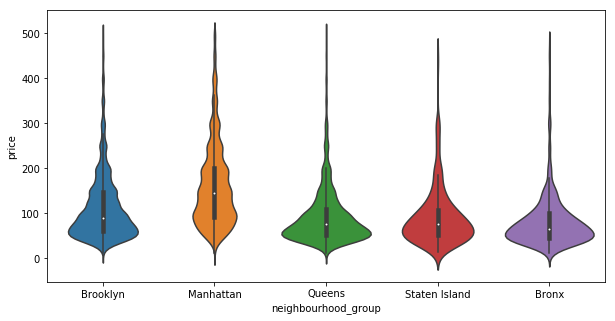

In [711]:
# Price by neighbourhood violin visualization
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 5))
sns.violinplot(data=price_by_neighbourhood_1, x='neighbourhood_group', y='price');

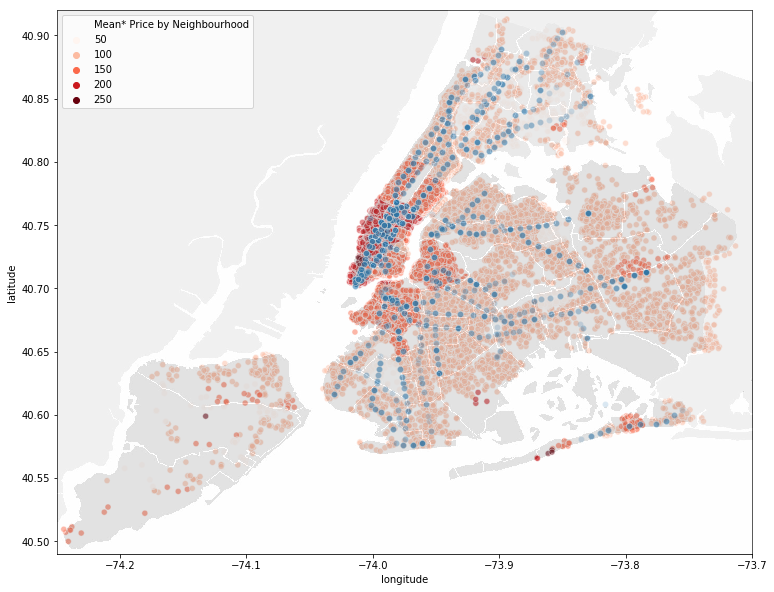

In [714]:
# adding subway access

subway_stops = pd.read_csv('NYC_Transit_Subway_Entrance_And_Exit_Data.csv')

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(14, 10))
map_img = plt.imread('New_York_City_.png', 0)
plt.imshow(map_img, extent=[-74.250, -73.7, 40.49, 40.92], alpha=0.2, zorder=3)
sns.scatterplot(data=subway_stops, x='Station Longitude', y='Station Latitude', zorder=1, alpha=0.2)
sns.scatterplot(data=price_by_neighbourhood_1, x='longitude', y='latitude', hue='Mean* Price by Neighbourhood', palette=plt.get_cmap('Reds'), legend='full', zorder=0, alpha=0.6);

In [727]:
# top 20 landmarks
names = ['Statue of Liberty', 'Central Park', 'Rockefeller Center',
        'Metropolitan Museum of Art', 'Broadway Theatre', 'Empire State Building',
        'National September 11 Memorial & Museum', 'High Line', 'Times Square',
        'Brooklyn Bridge', 'Fifth Avenue', 'Grand Central Terminal',
        'One World Observatory', 'Frick Collection', 'New York Public Library',
        'Wall Street', 'Radio City Music Hall', "St. Patrick's Cathedral",
        'Carnegie Hall', 'Bryant Park']

locations = [(40.6892, -74.0445), (40.7829, -73.9654), (40.7587, -73.9787), 
            (40.7794, -73.9632), (40.7633, -73.9832), (40.7484, -73.9857),
            (40.7115, -74.0134), (40.7480, -74.0048), (40.7580, -73.9855),
            (40.7061, -73.9969), (40.731412, -73.996985), (40.7527, -73.9772),
            (40.7133, -74.0134), (40.7712, -73.9674), (40.753181, -73.982254),
            (40.7038, -74.0057), (40.7600, -73.9800), (40.7585, -73.9760),
            (40.7651, -73.9799), (40.7536, -73.9832)]

locations_arr = np.array(locations)
top_20_landmarks = pd.DataFrame(data = {'Name': names, 'Location': locations, 'longitude': locations_arr[:,1], 'latitude': locations_arr[:, 0]})
top_20_landmarks.head()

,Name,Location,longitude,latitude
0,Statue of Liberty,"(40.6892, -74.0445)",-74.0445,40.6892
1,Central Park,"(40.7829, -73.9654)",-73.9654,40.7829
2,Rockefeller Center,"(40.7587, -73.9787)",-73.9787,40.7587
3,Metropolitan Museum of Art,"(40.7794, -73.9632)",-73.9632,40.7794
4,Broadway Theatre,"(40.7633, -73.9832)",-73.9832,40.7633


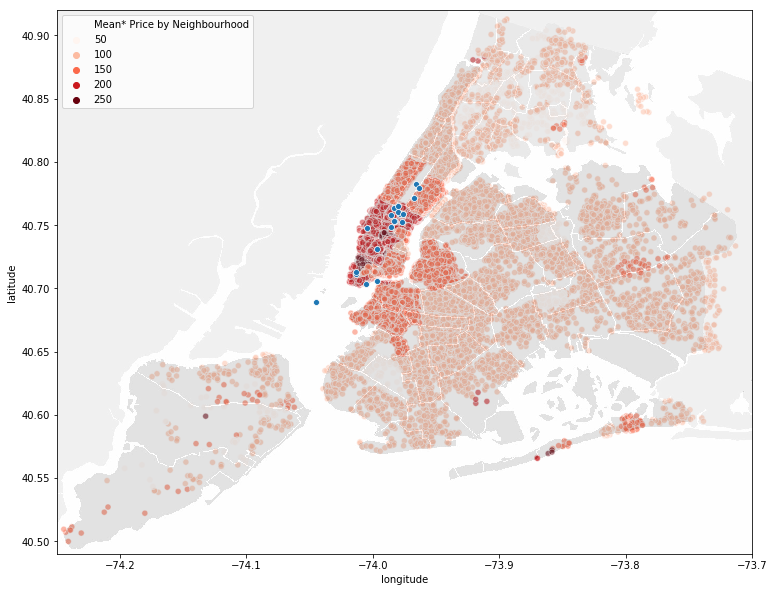

In [726]:
# adding landmarks to plot
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(20, 10))
map_img = plt.imread('New_York_City_.png', 0)
plt.imshow(map_img, extent=[-74.250, -73.7, 40.49, 40.92], alpha=0.2, zorder=1)
sns.scatterplot(data=top_20_landmarks, x='longitude', y='latitude', palette=plt.get_cmap('Reds'), legend='full', zorder=2)
sns.scatterplot(data=price_by_neighbourhood_1, x='longitude', y='latitude', hue='Mean* Price by Neighbourhood', palette=plt.get_cmap('Reds'), legend='full', zorder=0, alpha=0.6);

In [595]:
#one hot encoding neighborhood/room_type
clean_df = pd.concat([clean_df, pd.get_dummies(new_df["neighbourhood"], drop_first=False)], axis=1)
clean_df = pd.concat([clean_df, pd.get_dummies(new_df["neighbourhood_group"], drop_first=False)], axis=1)
clean_df = pd.concat([clean_df, pd.get_dummies(new_df["room_type"], drop_first=False)], axis=1)

In [605]:
#select input variables, drop tar
X = clean_df.drop(['price'], axis=1)
y = clean_df['price']

In [606]:
print(X.shape)
print(y.shape)

(47236, 237)
(47236,)


In [665]:
#split data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)

(37788, 237)
(9448, 237)


In [666]:
# adding in feautures for average price based on neighborhood/room_type
temp = pd.concat([y_train, X_train], axis=1)
neighbourhood_avgs = {}
neighbourhood_group_avgs = {}
room_type_avgs = {}

for n in temp['neighbourhood'].unique():
    neighbourhood_avgs[n] = temp.loc[temp['neighbourhood'] == n, 'price'].mean()

for n in temp['neighbourhood_group'].unique():
    neighbourhood_group_avgs[n] = temp.loc[temp['neighbourhood_group'] == n, 'price'].mean()

for r in temp['room_type'].unique():
    room_type_avgs[r] = temp.loc[temp['room_type'] == r, 'price'].mean()

In [667]:
#mapping average prices of neighborhoods/room_types 
X_train['neighbourhood_avg'] = X_train.loc[:, 'neighbourhood'].map(neighbourhood_avgs)
X_train['neighbourhood_group_avg'] = X_train.loc[:, 'neighbourhood_group'].map(neighbourhood_group_avgs)
X_train['room_type_avg'] = X_train.loc[:, 'room_type'].map(room_type_avgs)

#mapping average prices from training data to test set
X_test['neighbourhood_avg'] = X_test.loc[:, 'neighbourhood'].map(neighbourhood_avgs)
X_test['neighbourhood_group_avg'] = X_test.loc[:, 'neighbourhood_group'].map(neighbourhood_group_avgs)
X_test['room_type_avg'] = X_test.loc[:, 'room_type'].map(room_type_avgs)

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [668]:
# adding crime rates by borough 
X_train['crime_rates'] = X_train.loc[:, 'neighbourhood_group'].map(crime_rates)
X_test['crime_rates'] = X_test.loc[:, 'neighbourhood_group'].map(crime_rates)

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [669]:
# adding median sale price of homes/apartments by borough

X_train['median_sale_price'] = X_train.loc[:, 'neighbourhood_group'].map(sales_dict)
X_test['median_sale_price'] = X_test.loc[:, 'neighbourhood_group'].map(sales_dict)

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [671]:
#adding distance to landmark feature
from geopy import distance

def dist(row):
    coords_A = (row['latitude'], row['longitude'])
    distances = []
    for coords_B in top_20_landmarks['Location']:
        d = distance.distance(coords_A, coords_B).miles
        distances.append(d)
    return min(distances)

In [672]:
# adding feature, this takes some time ~5min
X_train['min_dist_to_landmark'] = X_train.apply(dist, axis = 1)
X_test['min_dist_to_landmark'] = X_test.apply(dist, axis = 1)

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [677]:
#drop the neighbourhood/room_type columns
X_train.drop(['neighbourhood', 'neighbourhood_group', 'room_type'],axis=1, inplace=True)
X_test.drop(['neighbourhood', 'neighbourhood_group', 'room_type'],axis=1, inplace=True)

/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [678]:
print(X_train.shape)
print(X_test.shape)

(37788, 240)
(9448, 240)


In [682]:
# scaling the data
from sklearn.preprocessing import RobustScaler, MinMaxScaler

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [691]:
# scaling results in 2 null values for neighborhood_avg, so replace this with 0
X_test = pd.DataFrame(X_test)
X_test.fillna(0, inplace = True)
X_test.isnull().sum()

0      0
1      0
2      0
3      0
4      0
5      0
6      0
7      0
8      0
9      0
10     0
11     0
12     0
13     0
14     0
15     0
16     0
17     0
18     0
19     0
20     0
21     0
22     0
23     0
24     0
25     0
26     0
27     0
28     0
29     0
      ..
210    0
211    0
212    0
213    0
214    0
215    0
216    0
217    0
218    0
219    0
220    0
221    0
222    0
223    0
224    0
225    0
226    0
227    0
228    0
229    0
230    0
231    0
232    0
233    0
234    0
235    0
236    0
237    0
238    0
239    0
Length: 240, dtype: int64

## Modeling

In [798]:
from sklearn.tree            import DecisionTreeRegressor
from sklearn.neural_network  import MLPRegressor
from sklearn.linear_model    import LinearRegression, Ridge
from sklearn.ensemble        import RandomForestRegressor, AdaBoostRegressor
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics         import mean_squared_error, r2_score

### Training/Validation

In [636]:
# this function will perform 5-fold validation on the training data

def cross_validate(model):
    kf = KFold(5, shuffle = True, random_state=42)
    mse = cross_val_score(model ,X_train,y_train, scoring = "neg_mean_squared_error", cv=kf) 
    avg_rmse = np.sqrt(np.absolute(mse)).mean()
    return avg_rmse

In [829]:
# putting models in dictionary and running 5-fold validation on each of them
errors_dict = {}
models = {'Ridge': Ridge(fit_intercept = True),
         'Decision Tree (10)': DecisionTreeRegressor(min_samples_leaf=10),
         'Decision Tree (20)': DecisionTreeRegressor(min_samples_leaf=20),
         'Decision Tree (30)': DecisionTreeRegressor(min_samples_leaf=30),
         'Decision Tree (40)': DecisionTreeRegressor(min_samples_leaf=40),
         'Decision Tree (50)': DecisionTreeRegressor(min_samples_leaf=50),
         'Random Forest (100)': RandomForestRegressor(n_estimators = 100, random_state=42,  min_samples_leaf=2),
         'Random Forest (200)': RandomForestRegressor(n_estimators = 200, random_state=42,  min_samples_leaf=2),
         'Random Forest (300)': RandomForestRegressor(n_estimators = 300, random_state=42,  min_samples_leaf=2),
         'Multilayer Perceptron': MLPRegressor(activation='relu', max_iter=1000)
         }

for k, v in models.items():
    avg_rmse = cross_validate(v)
    print(k + f" RMSE: {avg_rmse}")
    errors_dict[k] = avg_rmse

Ridge RMSE: 61.17480270185138
Decision Tree (10) RMSE: 64.59569345258328
Decision Tree (20) RMSE: 61.94445801962295
Decision Tree (30) RMSE: 61.07082914018015
Decision Tree (40) RMSE: 60.70756185684432
Decision Tree (50) RMSE: 60.358621765452064
Random Forest (100) RMSE: 57.98304294618347
Random Forest (200) RMSE: 57.87535873535545
Random Forest (300) RMSE: 57.82013170400156
Multilayer Perceptron RMSE: 59.9763435604057


In [830]:
models_df = pd.DataFrame.from_dict(errors_dict, orient = 'index')
models_df.rename(columns = {0: 'RMSE'}, inplace=True)
models_df

,RMSE
Ridge,61.174803
Decision Tree (10),64.595693
Decision Tree (20),61.944458
Decision Tree (30),61.070829
Decision Tree (40),60.707562
Decision Tree (50),60.358622
Random Forest (100),57.983043
Random Forest (200),57.875359
Random Forest (300),57.820132
Multilayer Perceptron,59.976344


### Testing

In [695]:
final_model = RandomForestRegressor(n_estimators = 300, random_state=42,  min_samples_leaf=2)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Final Model RMSE: {rmse}')

Final Model RMSE: 57.60144674747107


In [745]:
predictions = pd.DataFrame(data = {"Predictions": y_pred, "Ground Truth": y_test, "Difference": abs(y_pred - y_test)})
top_5 = predictions.sort_values('Difference').reset_index(drop = True).head()
worst_5 = predictions.sort_values('Difference', ascending= False).reset_index(drop = True).head()

In [746]:
top_5

,Predictions,Ground Truth,Difference
0,48.010000,48,0.010000
1,70.014294,70,0.014294
2,149.982799,150,0.017201
3,42.017623,42,0.017623
4,75.019372,75,0.019372


In [747]:
worst_5

,Predictions,Ground Truth,Difference
0,110.589138,477,366.410862
1,97.498325,450,352.501675
2,165.048167,499,333.951833
3,133.686774,450,316.313226
4,136.051262,450,313.948738
